# 유의판매자 분류 모델링

## 분석 순서
### 사전 분석
0. **분포 확인**: approved-carrier 주문 방치, 리뷰 평균별점, 1~3점(low) 리뷰 비율
   - 통계: 25%, 50%, 75%, 90%, mean, std, median

### 피처 검증
1. **상관계수 & VIF 확인**: 다중공선성 검토

### 판매자 분류 기준
- **판매건수 75% 이상**: 엄격한 기준 (각 항목 75% 수준)
- **판매건수 50-75%**: 유한 기준 (각 항목 90% 수준)

### 유의판매자 기준
1. **주문 방치**: approve -> carrier (Q3 기준, 카테고리/결제수단별 차이 확인)
2. **리뷰 분석**: 
   - 평균별점 기준 (3.5점)
   - 1~3점(low) 리뷰 비율
   - -> 둘 중 선택


In [2]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df = pd.read_csv('./Olist_DataSet/ML_olist.csv')
print(f"데이터 크기: {df.shape}")
print(f"\n컬럼 목록: {df.columns.tolist()}")
df.head()


데이터 크기: (85804, 11)

컬럼 목록: ['order_id', 'order_approved_at', 'order_delivered_carrier_date', 'seller_id', 'shipping_limit_date', 'product_category_name_english', 'review_score', 'review_comment_message', 'payment_types', 'has_text_review', 'seller_processing_days']


,order_id,order_approved_at,order_delivered_carrier_date,seller_id,shipping_limit_date,product_category_name_english,review_score,review_comment_message,payment_types,has_text_review,seller_processing_days
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,2017-10-04 19:55:00,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,housewares,4.0,"Não testei o produto ainda, mas ele veio corre...","credit_card,voucher",True,2.37
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,2018-07-26 14:31:00,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,perfumery,4.0,Muito bom o produto.,boleto,True,0.46
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23,2018-08-08 13:50:00,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,auto,5.0,NaN,credit_card,False,0.20
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59,2017-11-22 13:39:59,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,pet_shop,5.0,O produto foi exatamente o que eu esperava e e...,credit_card,True,3.75
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29,2018-02-14 19:46:34,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,stationery,5.0,NaN,credit_card,False,0.89


## 1. 판매자별 데이터 집계
- 판매건수, 평균 처리시간, 리뷰 평균, 1~3점 비율 등 계산

In [3]:
# 월 컬럼 생성 (order_approved_at에서 추출)
df['order_month'] = pd.to_datetime(df['order_approved_at']).dt.month

# 판매자별 집계
seller_agg = df.groupby('seller_id').agg({
    'order_id': 'count',  # 총 주문 수
    'review_score': ['mean', 'std'],  # 리뷰 평균, 표준편차
    'seller_processing_days': 'mean',  # 처리시간 통계
    'product_category_name_english': 'nunique',  # 취급 카테고리 수
    'order_month': 'nunique'  # 활동 월 수
}).reset_index()

# 컬럼명 정리
seller_agg.columns = ['seller_id', 'total_orders', 'avg_review_score', 'std_review_score',
                      'avg_processing_days', 'category_count', 'active_months']

# 1~3점(low) 리뷰 비율 계산
low_review = df[df['review_score'].isin([1, 2, 3])].groupby('seller_id').size()
seller_agg['low_review_count'] = seller_agg['seller_id'].map(low_review).fillna(0).astype(int)
seller_agg['low_review_ratio'] = seller_agg['low_review_count'] / seller_agg['total_orders']

seller_agg.head().T

,0,1,2,3,4
seller_id,0015a82c2db000af6aaaf3ae2ecb0532,001cca7ae9ae17fb1caed9dfb1094831,002100f778ceb8431b7a1020ff7ab48f,003554e2dce176b5555353e4f3555ac8,004c9cd9d87a3c30c522c48c4fc07416
total_orders,1,183,48,1,133
avg_review_score,5.0,4.054645,4.25,5.0,4.300752
std_review_score,NaN,1.369715,1.139242,NaN,1.154602
avg_processing_days,5.08,2.206612,3.669375,0.52,1.442632
category_count,1,2,1,1,2
active_months,1,12,8,1,12
low_review_count,0,42,11,0,26
low_review_ratio,0.0,0.229508,0.229167,0.0,0.195489


## 0. 분포 확인 (25%, 50%, 75%, 90%, mean, std, median)
- approved-carrier 주문 방치 (`avg_processing_days`)
- 리뷰 평균별점 (`avg_review_score`)
- 1~3점(low) 리뷰 비율 (`low_review_ratio`)


In [4]:
# 주요 변수 분포 확인
target_cols = ['avg_processing_days', 'low_review_ratio']

def get_distribution_stats(series, name):
    """분포 통계 계산"""
    stats_dict = {
        'Variable': name,
        'Count': series.count(),
        'Mean': series.mean(),
        'Std': series.std(),
        'Median': series.median(),
        '25%': series.quantile(0.25),
        '50%': series.quantile(0.50),
        '75%': series.quantile(0.75),
        '90%': series.quantile(0.90)
    }
    return stats_dict

# 판매자 레벨 분포 통계
print("=" * 70)
print("판매자 레벨 주요 변수 분포 (seller_agg)")
print("=" * 70)

stats_list = []
for col in target_cols:
    stats_list.append(get_distribution_stats(seller_agg[col].dropna(), col))

stats_df = pd.DataFrame(stats_list)
stats_df = stats_df.set_index('Variable')
print(stats_df.round(4).to_string())

# 주문 레벨 분포
print("\n" + "=" * 70)
print("주문 레벨 분포 (df - seller_processing_days)")
print("=" * 70)
order_stats = get_distribution_stats(df['seller_processing_days'].dropna(), 'seller_processing_days')
print(pd.DataFrame([order_stats]).set_index('Variable').round(4).to_string())

판매자 레벨 주요 변수 분포 (seller_agg)
                     Count    Mean     Std  Median   25%     50%     75%     90%
Variable                                                                        
avg_processing_days   2817  3.0820  3.4230  2.1500  1.35  2.1500  3.5725  5.8539
low_review_ratio      2817  0.1899  0.2423  0.1285  0.00  0.1285  0.2619  0.5000

주문 레벨 분포 (df - seller_processing_days)
                        Count    Mean     Std  Median  25%   50%   75%   90%
Variable                                                                    
seller_processing_days  85804  2.8352  3.3526    1.85  0.9  1.85  3.62  6.02


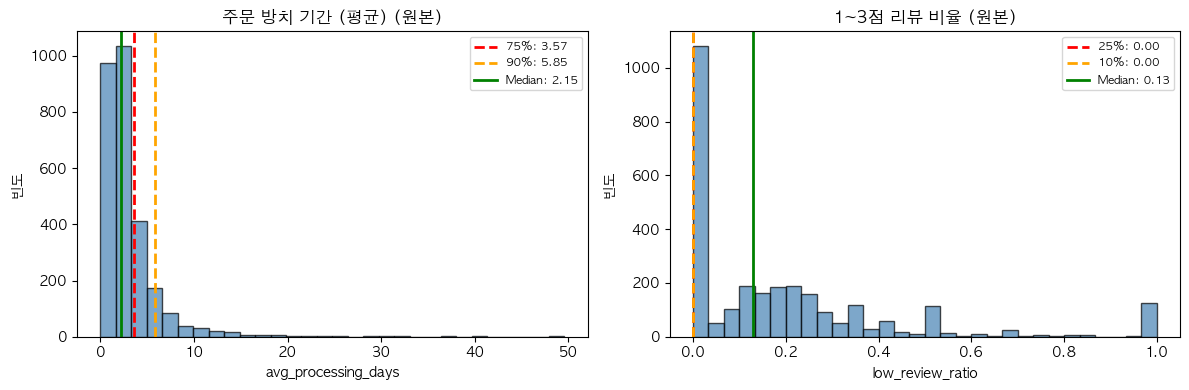

In [5]:
# 분포 시각화 (원본)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

titles = ['주문 방치 기간 (평균)', '1~3점 리뷰 비율']

for ax, col, title in zip(axes, target_cols, titles):
    data = seller_agg[col].dropna()
    
    ax.hist(data, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    
    # 1~3점 비율은 25%, 10% 기준 적용
    if col == 'low_review_ratio':
        ax.axvline(x=data.quantile(0.25), color='red', linestyle='--', linewidth=2, label=f'25%: {data.quantile(0.25):.2f}')
        ax.axvline(x=data.quantile(0.10), color='orange', linestyle='--', linewidth=2, label=f'10%: {data.quantile(0.10):.2f}')
    else:
        ax.axvline(x=data.quantile(0.75), color='red', linestyle='--', linewidth=2, label=f'75%: {data.quantile(0.75):.2f}')
        ax.axvline(x=data.quantile(0.90), color='orange', linestyle='--', linewidth=2, label=f'90%: {data.quantile(0.90):.2f}')
    
    ax.axvline(x=data.median(), color='green', linestyle='-', linewidth=2, label=f'Median: {data.median():.2f}')
    ax.set_xlabel(col)
    ax.set_ylabel('빈도')
    ax.set_title(f'{title} (원본)')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

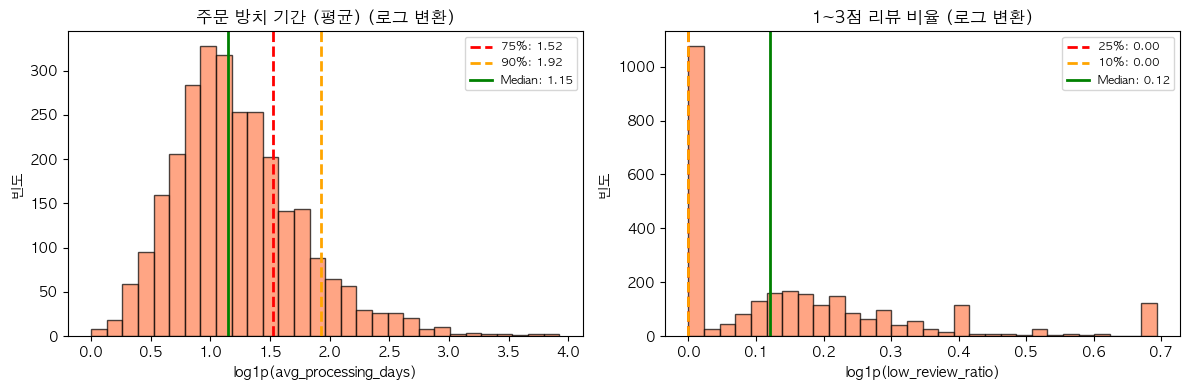

In [6]:
# 분포 시각화 (로그 변환)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

titles = ['주문 방치 기간 (평균)', '1~3점 리뷰 비율']

for ax, col, title in zip(axes, target_cols, titles):
    data = seller_agg[col].dropna()
    # log1p: log(1+x) - 0값 처리 가능
    data_log = np.log1p(data)
    
    ax.hist(data_log, bins=30, edgecolor='black', alpha=0.7, color='coral')
    
    # 로그 변환된 분위수 표시
    if col == 'low_review_ratio':
        ax.axvline(x=np.log1p(data.quantile(0.25)), color='red', linestyle='--', linewidth=2, 
                   label=f'25%: {np.log1p(data.quantile(0.25)):.2f}')
        ax.axvline(x=np.log1p(data.quantile(0.10)), color='orange', linestyle='--', linewidth=2, 
                   label=f'10%: {np.log1p(data.quantile(0.10)):.2f}')
    else:
        ax.axvline(x=np.log1p(data.quantile(0.75)), color='red', linestyle='--', linewidth=2, 
                   label=f'75%: {np.log1p(data.quantile(0.75)):.2f}')
        ax.axvline(x=np.log1p(data.quantile(0.90)), color='orange', linestyle='--', linewidth=2, 
                   label=f'90%: {np.log1p(data.quantile(0.90)):.2f}')
    
    ax.axvline(x=data_log.median(), color='green', linestyle='-', linewidth=2, 
               label=f'Median: {data_log.median():.2f}')
    ax.set_xlabel(f'log1p({col})')
    ax.set_ylabel('빈도')
    ax.set_title(f'{title} (로그 변환)')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [7]:
print("=" * 60)
print("원본 vs 로그 변환")
print("=" * 60)
print(f"{'변수':<25} {'원본 왜도':>12} {'로그 왜도':>12}")
print("-" * 60)
for col in target_cols:
    data = seller_agg[col].dropna()
    skew_orig = data.skew()
    skew_log = np.log1p(data).skew()
    print(f"{col:<25} {skew_orig:>12.4f} {skew_log:>12.4f}")
print("=" * 60)
print("※ 왜도 0에 가까울수록 정규분포에 가까움")

원본 vs 로그 변환
변수                               원본 왜도        로그 왜도
------------------------------------------------------------
avg_processing_days             5.3677       0.9142
low_review_ratio                1.8420       1.3563
※ 왜도 0에 가까울수록 정규분포에 가까움


## 2. 상관계수 & VIF 확인
- X 변수들 간의 상관관계 확인
- VIF로 다중공선성 검토
- VIF > 10: 심각한 다중공선성

In [8]:
# X 변수 선택 (잠재적 피처)
feature_cols = ['total_orders', 'avg_processing_days', 'low_review_ratio', 
                'category_count', 'active_months']

X_data = seller_agg[feature_cols].dropna()

# 상관계수 계산
corr_matrix = X_data.corr()

corr_matrix

,total_orders,avg_processing_days,low_review_ratio,category_count,active_months
total_orders,1.000000,-0.023020,0.018243,0.381888,0.465970
avg_processing_days,-0.023020,1.000000,0.281365,-0.042572,-0.059979
low_review_ratio,0.018243,0.281365,1.000000,0.019959,0.004851
category_count,0.381888,-0.042572,0.019959,1.000000,0.484395
active_months,0.465970,-0.059979,0.004851,0.484395,1.000000


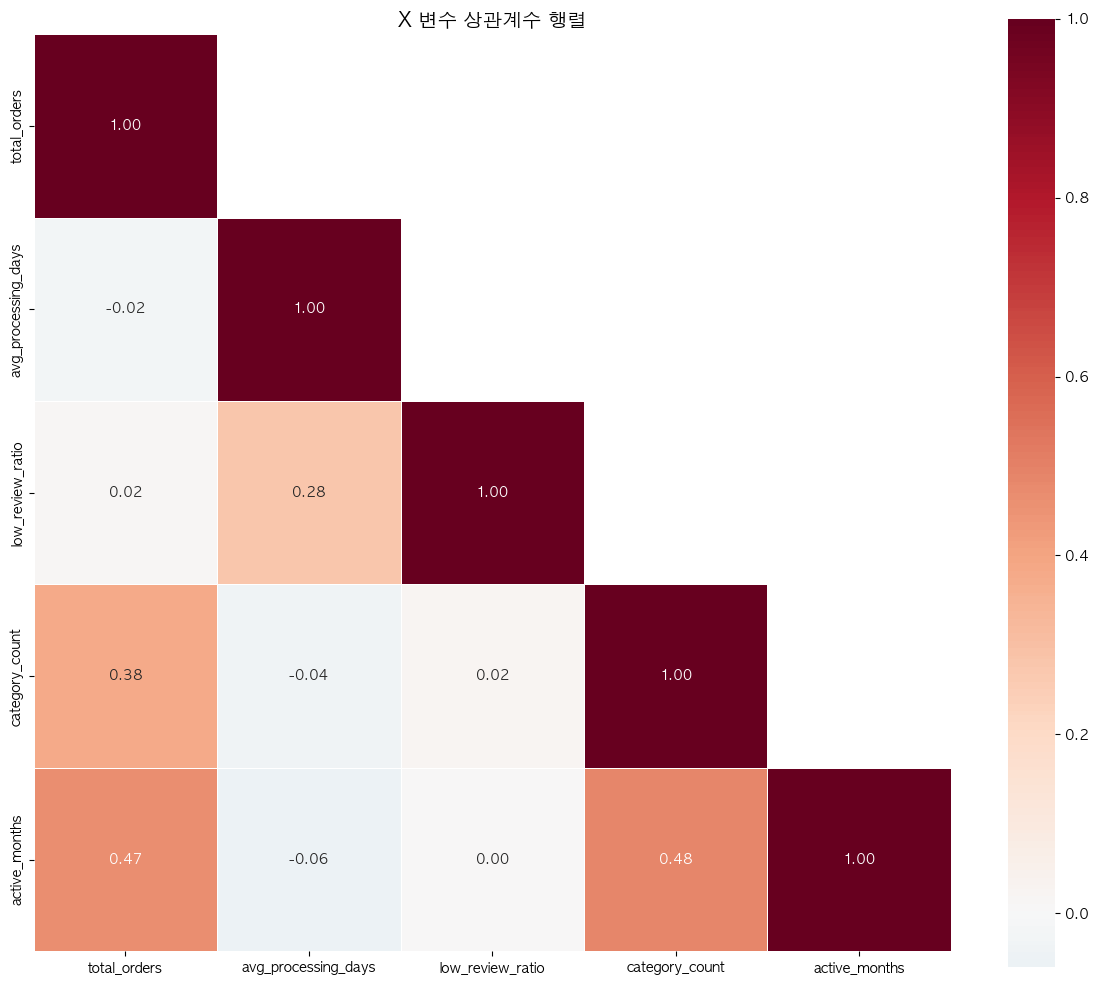

In [9]:
# 상관계수 히트맵
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            mask=mask, square=True, linewidths=0.5, ax=ax)
ax.set_title('X 변수 상관계수 행렬', fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
# VIF 계산
from sklearn.preprocessing import StandardScaler

# 스케일링 (VIF 계산 전)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

# VIF 계산 함수
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Variable'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

vif_result = calculate_vif(X_scaled_df)

print("=" * 50)
print("VIF > 10: 심각한 다중공선성")
print("VIF > 5: 중간 수준 다중공선성")
print("=" * 50)
print(vif_result.to_string(index=False))

VIF > 10: 심각한 다중공선성
VIF > 5: 중간 수준 다중공선성
           Variable      VIF
      active_months 1.489112
     category_count 1.363099
       total_orders 1.331857
avg_processing_days 1.090987
   low_review_ratio 1.087405


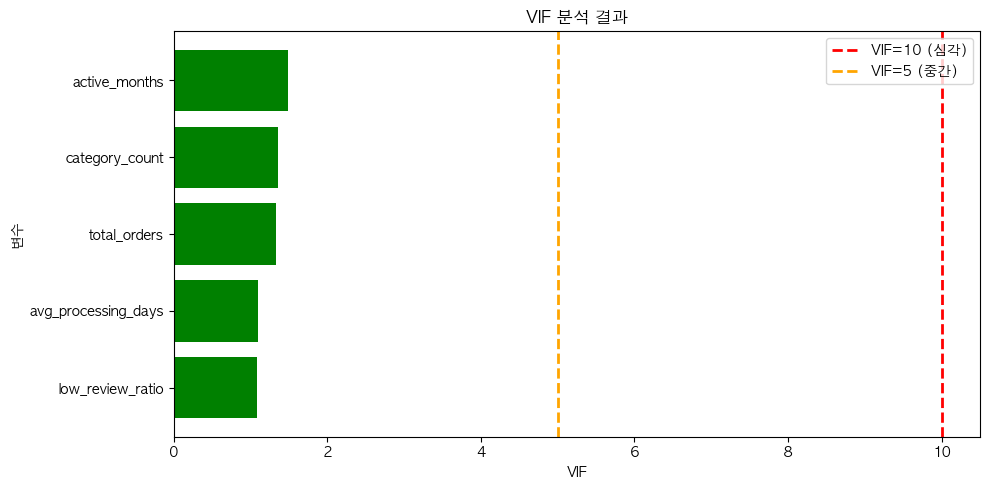

In [11]:
# VIF 시각화
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['red' if v > 10 else 'orange' if v > 5 else 'green' for v in vif_result['VIF']]
bars = ax.barh(vif_result['Variable'], vif_result['VIF'], color=colors)
ax.axvline(x=10, color='red', linestyle='--', linewidth=2, label='VIF=10 (심각)')
ax.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF=5 (중간)')
ax.set_xlabel('VIF')
ax.set_ylabel('변수')
ax.set_title('VIF 분석 결과')
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

- total_orders가 많다고 해서 avg_processing_days, low_review_ratio가 반드시 커지거나 작아지지 않는다

## 3. 판매건수 기준 판매자 분류
- **75% 이상**: 엄격한 기준 적용 (각 항목 75% 수준)
- **50-75%**: 유한 기준 적용 (각 항목 90% 수준)
- **50% 미만**: 분석 제외

In [12]:
# 판매건수 분포 확인
print("=== 판매건수 (total_orders) 분포 ===")
print(seller_agg['total_orders'].describe())

# 판매건수 분위수
q50_orders = seller_agg['total_orders'].quantile(0.50)
q75_orders = seller_agg['total_orders'].quantile(0.75)

print(f"\n판매건수 50%: {q50_orders}")
print(f"판매건수 75%: {q75_orders}")

# 판매자 그룹 분류
seller_agg['seller_group'] = pd.cut(
    seller_agg['total_orders'],
    bins=[-np.inf, q50_orders, q75_orders, np.inf],
    labels=['하위(~50%)', '중위(50-75%)', '상위(75%~)']
)

=== 판매건수 (total_orders) 분포 ===
count    2817.000000
mean       30.459354
std        95.413900
min         1.000000
25%         2.000000
50%         7.000000
75%        21.000000
max      1620.000000
Name: total_orders, dtype: float64

판매건수 50%: 7.0
판매건수 75%: 21.0


In [13]:
upper_group = seller_agg[seller_agg['seller_group'] == '상위(75%~)']
middle_group = seller_agg[seller_agg['seller_group'] == '중위(50-75%)']

# 기준 변수들
criterion_cols = ['avg_processing_days', 'low_review_ratio']

print("=" * 70)
print("그룹별 기준값 (엄격/유한)")
print("=" * 70)

criteria_summary = []

for col in criterion_cols:
    # low_review_ratio는 반대로 25%, 10% 기준 적용
    if col == 'low_review_ratio':
        upper_strict = upper_group[col].quantile(0.25)  # 엄격: 25%
        upper_lenient = upper_group[col].quantile(0.10)  # 유한: 10%
        middle_strict = middle_group[col].quantile(0.25)
        middle_lenient = middle_group[col].quantile(0.10)
        criteria_summary.append({
            'Variable': col,
            '상위그룹_25%': upper_strict,
            '상위그룹_10%': upper_lenient,
            '중위그룹_25%': middle_strict,
            '중위그룹_10%': middle_lenient
        })
    else:
        upper_75 = upper_group[col].quantile(0.75)
        upper_90 = upper_group[col].quantile(0.90)
        middle_75 = middle_group[col].quantile(0.75)
        middle_90 = middle_group[col].quantile(0.90)
        criteria_summary.append({
            'Variable': col,
            '상위그룹_75%': upper_75,
            '상위그룹_90%': upper_90,
            '중위그룹_75%': middle_75,
            '중위그룹_90%': middle_90
        })

criteria_df = pd.DataFrame(criteria_summary)
print(criteria_df.round(4).to_string(index=False))

그룹별 기준값 (엄격/유한)
           Variable  상위그룹_75%  상위그룹_90%  중위그룹_75%  중위그룹_90%  상위그룹_25%  상위그룹_10%  중위그룹_25%  중위그룹_10%
avg_processing_days    3.3462    5.0065    3.4524    5.3552       NaN       NaN       NaN       NaN
   low_review_ratio       NaN       NaN       NaN       NaN    0.1293    0.0833    0.0817       0.0


## 4. 주문 방치 분석 (approve -> carrier)
- 카테고리별 차이 확인
- 결제수단별 차이 확인

In [14]:
# 카테고리별 주문 방치 기간 분석
category_processing = df.groupby('product_category_name_english')['seller_processing_days'].agg(['mean', 'median', 'std', 'count'])
category_processing = category_processing.sort_values('mean', ascending=False)

print("=== 카테고리별 주문 처리 시간 (상위 20개) ===")
print(category_processing.head(20).round(2).to_string())

=== 카테고리별 주문 처리 시간 (상위 20개) ===
                                mean  median   std  count
product_category_name_english                            
office_furniture               10.12    9.66  5.83   1276
fashion_shoes                   5.64    4.53  4.89    204
fashion_male_clothing           4.51    2.94  4.97    104
home_appliances_2               4.51    3.53  4.65    166
home_construction               4.23    2.92  3.75    458
fashio_female_clothing          4.05    2.73  3.54     44
fashion_underwear_beach         3.78    2.15  4.44    100
furniture_bedroom               3.77    2.95  3.41     89
music                           3.57    1.99  5.60     29
furniture_living_room           3.55    2.32  3.64    392
air_conditioning                3.52    2.04  4.44    219
consoles_games                  3.51    2.12  4.71    829
art                             3.47    2.70  2.86    158
construction_tools_safety       3.37    1.81  4.67    139
diapers_and_hygiene             3.31    

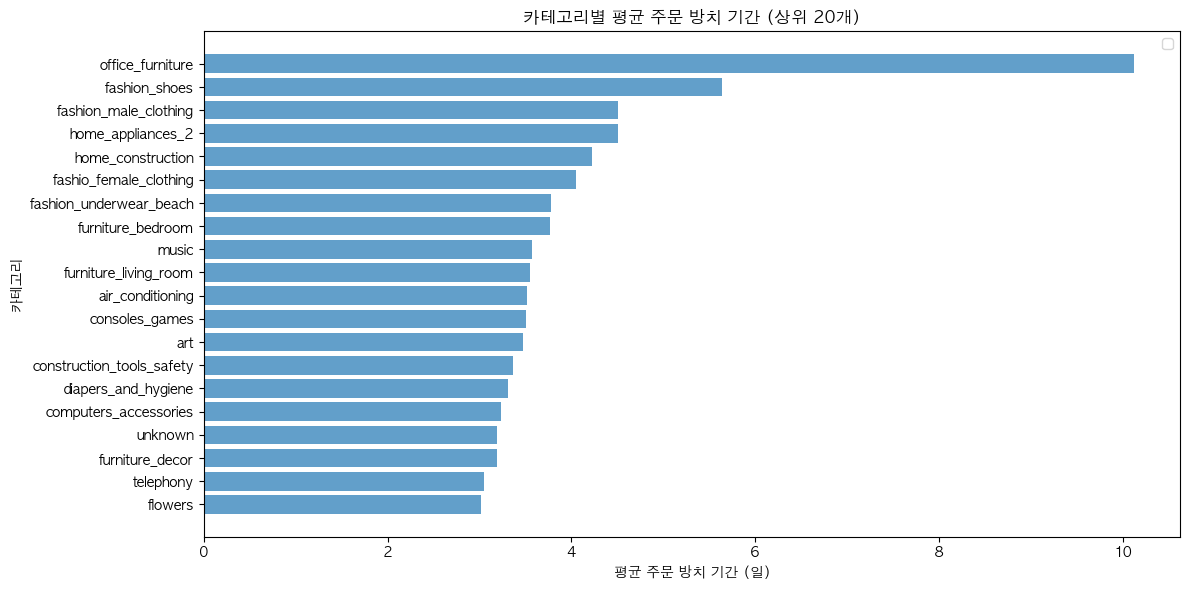

In [15]:
# 상위 20개 카테고리 시각화
top_categories = category_processing.head(20)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_categories.index, top_categories['mean']
               , capsize=3, alpha=0.7)
ax.set_xlabel('평균 주문 방치 기간 (일)')
ax.set_ylabel('카테고리')
ax.set_title('카테고리별 평균 주문 방치 기간 (상위 20개)')
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

**카테고리별 주문 처리 지연(Processing Days) 분석**
* **`office_furniture`:** 평균 **10.1일** 소요. 타 카테고리 대비 2배 이상의 시간이 걸리는 **구조적 병목** 현상 확인
* **`computers`, `telephony`:** 주문량(수천 건)이 가장 많음에도 평균 **3일** 내 처리. 물류 시스템 최적화 상태
* **`fashion` 계열:** 중앙값(3~4일) 대비 평균이 높음. 일부 주문의 극단적 지연이 발생하고 있음

In [16]:
# 카테고리별 ANOVA 검정
from scipy.stats import f_oneway

# 주요 카테고리 (건수 100건 이상)
major_categories = category_processing[category_processing['count'] >= 100].index.tolist()
category_groups = [df[df['product_category_name_english'] == cat]['seller_processing_days'].dropna() 
                   for cat in major_categories[:10]]

f_stat, p_value = f_oneway(*category_groups)
print(f"\n=== ANOVA 검정 (상위 10개 주요 카테고리) ===")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"결론: {'카테고리별 유의한 차이 있음' if p_value < 0.05 else '카테고리별 유의한 차이 없음'}")


=== ANOVA 검정 (상위 10개 주요 카테고리) ===
F-statistic: 160.5557
P-value: 3.8134e-259
결론: 카테고리별 유의한 차이 있음


### ANOVA 검정 결과 요약

* **가설 설정:**
    * 귀무가설 : 모든 카테고리의 평균 주문 처리 기간은 같다.
    * 대립가설 : 적어도 하나의 카테고리는 평균 처리 기간이 다르다.

* **검정 결과:**
    * **F-statistic:** 160.56 (매우 높음)
    * **P-value:** 사실상 0

* **해석 및 결론:**
    * P-value가 유의수준(0.05)보다 현저히 낮으므로 귀무가설을 강력히 반박
    * **카테고리별로 처리 속도에 명확한 차이가 존재**

In [17]:
# 결제수단별 주문 방치 기간 분석
# payment_types 컬럼에서 주요 결제수단 추출
df['primary_payment'] = df['payment_types'].apply(lambda x: x.split(',')[0] if pd.notna(x) else 'unknown')

payment_processing = df.groupby('primary_payment')['seller_processing_days'].agg(['mean', 'median', 'std', 'count'])
payment_processing = payment_processing.sort_values('count', ascending=False)

print("=== 결제수단별 주문 방치 기간 ===")
print(payment_processing.round(2).to_string())

=== 결제수단별 주문 방치 기간 ===
                 mean  median   std  count
primary_payment                           
credit_card      2.82    1.90  3.25  63277
boleto           2.90    1.66  3.72  19274
voucher          2.77    1.94  2.92   1986
debit_card       2.74    1.69  3.22   1267


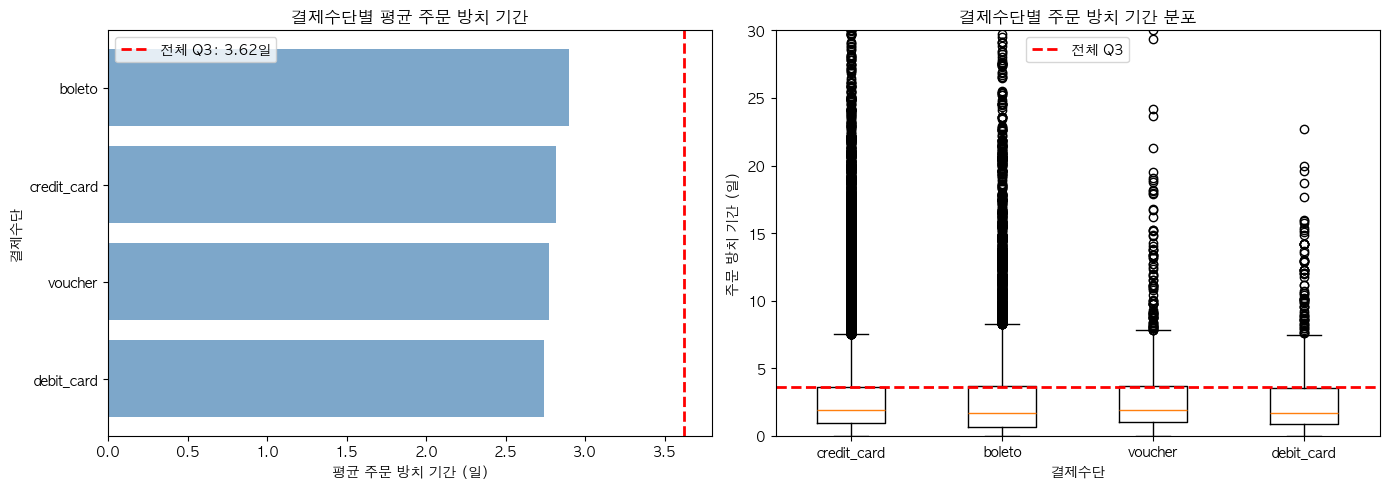

In [18]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 평균 비교
payment_sorted = payment_processing.sort_values('mean', ascending=True)
axes[0].barh(payment_sorted.index, payment_sorted['mean'], alpha=0.7, color='steelblue')
axes[0].axvline(x=df['seller_processing_days'].quantile(0.75), color='red', 
                linestyle='--', linewidth=2, label=f'전체 Q3: {df["seller_processing_days"].quantile(0.75):.2f}일')
axes[0].set_xlabel('평균 주문 방치 기간 (일)')
axes[0].set_ylabel('결제수단')
axes[0].set_title('결제수단별 평균 주문 방치 기간')
axes[0].legend()

payment_data = [df[df['primary_payment'] == p]['seller_processing_days'].dropna() 
                for p in payment_processing.index]
axes[1].boxplot(payment_data, labels=payment_processing.index, vert=True)
axes[1].axhline(y=df['seller_processing_days'].quantile(0.75), color='red', 
                linestyle='--', linewidth=2, label=f'전체 Q3')
axes[1].set_xlabel('결제수단')
axes[1].set_ylabel('주문 방치 기간 (일)')
axes[1].set_title('결제수단별 주문 방치 기간 분포')
axes[1].set_ylim(0, 30)
axes[1].legend()

plt.tight_layout()
plt.show()

In [19]:
# 결제수단별 ANOVA 검정
payment_groups = [df[df['primary_payment'] == p]['seller_processing_days'].dropna() 
                  for p in payment_processing.index if payment_processing.loc[p, 'count'] >= 100]

f_stat_pay, p_value_pay = f_oneway(*payment_groups)
print(f"\n=== ANOVA 검정 (결제수단) ===")
print(f"F-statistic: {f_stat_pay:.4f}")
print(f"P-value: {p_value_pay:.4e}")
print(f"결론: {'결제수단별 유의한 차이 있음' if p_value_pay < 0.05 else '결제수단별 유의한 차이 없음'}")


=== ANOVA 검정 (결제수단) ===
F-statistic: 3.4069
P-value: 1.6785e-02
결론: 결제수단별 유의한 차이 있음


### 결제수단별 ANOVA 검정 상세 해석

* **결과:** P-value가 0.016으로 유의수준(0.05)보다 낮아 통계적으로 유의미한 차이가 확인됨.
* **해석의 주의점:**
    * 그러나 F-statistic이 3.4로, 카테고리 변수(F=160.5)에 비해 영향력이 현저히 낮음.
    * 대규모 데이터 특성상 미세한 평균 차이도 통계적으로 감지된 것으로 판단됨.
* **최종 결론:**
    * 결제 수단 간에 통계적인 차이는 존재하나, **실질적인 배송 지연의 핵심 원인으로 보기는 어렵다.**
    * 모델링 시 변수로 포함은 하되, 중요도는 낮을 것으로 예상됨.

## 5. 리뷰 분석: 평균별점 vs 1~3점 비율 비교

- 선우님의 인사이트 채택하기로 함.

## 6. 그룹별 유의판매자 기준 적용
- 상위 그룹 (75%~): 엄격한 기준 (75% 수준)
- 중위 그룹 (50-75%): 유한 기준 (90% 수준)

In [20]:
# 그룹별 기준값 정의
# 상위 그룹: 엄격한 기준 (75% 수준, 단 low_ratio는 25%)
upper_processing_threshold = upper_group['avg_processing_days'].quantile(0.75)
upper_review_threshold = upper_group['avg_review_score'].quantile(0.25)  # 낮을수록 유의
upper_low_ratio_threshold = upper_group['low_review_ratio'].quantile(0.25)  # 25%로 변경 (반대)

# 중위 그룹: 유한 기준 (90% 수준, 단 low_ratio는 10%)
middle_processing_threshold = middle_group['avg_processing_days'].quantile(0.90)
middle_review_threshold = middle_group['avg_review_score'].quantile(0.10)  # 낮을수록 유의
middle_low_ratio_threshold = middle_group['low_review_ratio'].quantile(0.10)  # 10%로 변경 (반대)

print("=" * 70)
print("그룹별 유의판매자 기준값")
print("=" * 70)
print("\n[상위 그룹 (75% 이상) - 엄격한 기준]")
print(f"  - 주문 방치 > {upper_processing_threshold:.2f}일 (75% 수준)")
print(f"  - 1~3점 비율 > {upper_low_ratio_threshold:.2%} (25% 수준)")

print("\n[중위 그룹 (50-75%) - 유한 기준]")
print(f"  - 주문 방치 > {middle_processing_threshold:.2f}일 (90% 수준)")
print(f"  - 1~3점 비율 > {middle_low_ratio_threshold:.2%} (10% 수준)")

그룹별 유의판매자 기준값

[상위 그룹 (75% 이상) - 엄격한 기준]
  - 주문 방치 > 3.35일 (75% 수준)
  - 1~3점 비율 > 12.93% (25% 수준)

[중위 그룹 (50-75%) - 유한 기준]
  - 주문 방치 > 5.36일 (90% 수준)
  - 1~3점 비율 > 0.00% (10% 수준)


In [21]:
# 유의판매자 판정 함수
def classify_risky_seller(row):
    if row['seller_group'] == '상위(75%~)':
        processing_risky = row['avg_processing_days'] > upper_processing_threshold
        review_risky = row['avg_review_score'] < upper_review_threshold
        ratio_risky = row['low_review_ratio'] > upper_low_ratio_threshold
    elif row['seller_group'] == '중위(50-75%)':
        processing_risky = row['avg_processing_days'] > middle_processing_threshold
        review_risky = row['avg_review_score'] < middle_review_threshold
        ratio_risky = row['low_review_ratio'] > middle_low_ratio_threshold
    else:
        return 0  # 하위 그룹은 제외
    
    return 1 if (processing_risky or review_risky or ratio_risky) else 0

In [22]:
# 유의판매자 판정
seller_agg['is_risky_final'] = seller_agg.apply(classify_risky_seller, axis=1)

print(f"유의판매자: {seller_agg['is_risky_final'].sum()}명 ({seller_agg['is_risky_final'].mean()*100:.2f}%)")

유의판매자: 1048명 (37.20%)


In [23]:
# 그룹별 유의판매자 상세 분석
for group_name in ['상위(75%~)', '중위(50-75%)']:
    group_data = seller_agg[seller_agg['seller_group'] == group_name]
    risky_count = group_data['is_risky_final'].sum()
    total_count = len(group_data)
    
    print(f"\n[{group_name}]")
    print(f"  - 총 판매자: {total_count}명")
    print(f"  - 유의판매자: {risky_count}명 ({risky_count/total_count*100:.2f}%)")


[상위(75%~)]
  - 총 판매자: 696명
  - 유의판매자: 546명 (78.45%)

[중위(50-75%)]
  - 총 판매자: 616명
  - 유의판매자: 502명 (81.49%)


## 7. 분석 결과 요약

In [24]:
# 분석 결과 요약
print("=" * 70)
print("분석 결과 요약")
print("=" * 70)

print("\n[1. 분포 통계]")
print(stats_df.round(4).to_string())
print('-' * 70)

print("\n[2. VIF 결과 (다중공선성)]")
print(vif_result.to_string(index=False))
print('-' * 70)


print("\n[3. 상관계수]")
print(f"{corr_matrix}")
print('-' * 70)


print("\n[4. 카테고리/결제수단별 차이]")
print(f"  - 카테고리별 ANOVA p-value: {p_value:.4e} -> {'유의한 차이' if p_value < 0.05 else '차이 없음'}")
print(f"  - 결제수단별 ANOVA p-value: {p_value_pay:.4e} -> {'유의한 차이' if p_value_pay < 0.05 else '차이 없음'}")
print('-' * 70)


print("\n[5. 리뷰 기준 비교]")
print("선우님 인사이트 채택")
print('-' * 70)


print("\n[6. 최종 유의판매자]")
print(f"  - 상위 그룹: 주문방치/75%, 1~3점비율 25%")
print(f"  - 중위 그룹: 주문방치/ 90%, 1~3점비율 10%")
for group_name in ['상위(75%~)', '중위(50-75%)']:
    group_data = seller_agg[seller_agg['seller_group'] == group_name]
    risky_count = group_data['is_risky_final'].sum()
    total_count = len(group_data)
    
    print(f"\n[{group_name}]")
    print(f"  - 총 판매자: {total_count}명")
    print(f"  - 유의판매자: {risky_count}명 ({risky_count/total_count*100:.2f}%)")

분석 결과 요약

[1. 분포 통계]
                     Count    Mean     Std  Median   25%     50%     75%     90%
Variable                                                                        
avg_processing_days   2817  3.0820  3.4230  2.1500  1.35  2.1500  3.5725  5.8539
low_review_ratio      2817  0.1899  0.2423  0.1285  0.00  0.1285  0.2619  0.5000
----------------------------------------------------------------------

[2. VIF 결과 (다중공선성)]
           Variable      VIF
      active_months 1.489112
     category_count 1.363099
       total_orders 1.331857
avg_processing_days 1.090987
   low_review_ratio 1.087405
----------------------------------------------------------------------

[3. 상관계수]
                     total_orders  avg_processing_days  low_review_ratio  \
total_orders             1.000000            -0.023020          0.018243   
avg_processing_days     -0.023020             1.000000          0.281365   
low_review_ratio         0.018243             0.281365          1.000000   
cat

In [25]:
# 데이터 저장 (필요시)
# seller_agg.to_csv('./Olist_DataSet/seller_agg_with_risk.csv', index=False)